# Investigation
We will be investigating what variables will have the most impact on a house's market price.  We will be investigating from the perspective of a start up company which buys inexpensive houses and "flips" them for profit.

## Objectives:

* Find what aspects of a house have a significant impact on house's value
* Discover how much a house's value will change based on a changes in condition
* Find the areas that are more profitable to sell homes. 

# Obtaining data
Time to import the necessary libraries and initialize a data frame containing the data from the CSV file.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import stats
import statsmodels.stats.api as sms

sns.set_style('darkgrid')

## Initializing data frame

In [2]:
df = pd.read_csv('csv_files/kc_house_data.csv')
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB
None


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


# Scrubbing the Data
Now that the data frame has been initialized, we'll start cleaning.

Notes: Problems that I can immediately see are: 
* waterfront, view, and yr_renovated are missing values. 
* sqft_basement and dates are objects instead of integer/float and datetime, respectively. 

## Waterfront

In [3]:
print(df.waterfront.value_counts())
waterfront = df[df['waterfront'] == 1.0]
waterfront['price'].describe()


0.0    19075
1.0      146
Name: waterfront, dtype: int64


count    1.460000e+02
mean     1.717215e+06
std      1.145385e+06
min      2.850000e+05
25%      8.275000e+05
50%      1.510000e+06
75%      2.282500e+06
max      7.060000e+06
Name: price, dtype: float64

In [4]:
# Looked at low end prices of waterfront properties out of curiousity.
# waterfront will play a significant role in price.  Replacing NaN's with 
# median
df.waterfront.fillna(df['waterfront'].median(), inplace=True)
df.waterfront.isna().sum()

0

## Yr_renovated

In [5]:
# Checking out yr_renovated  ***Take deeper look into this***
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [6]:
# Since having data about renovated homes might be useful, filling NaN's with
# median
df.yr_renovated.fillna(df['yr_renovated'].median())

0           0.0
1        1991.0
2           0.0
3           0.0
4           0.0
          ...  
21592       0.0
21593       0.0
21594       0.0
21595       0.0
21596       0.0
Name: yr_renovated, Length: 21597, dtype: float64

### Is It Categorical? 

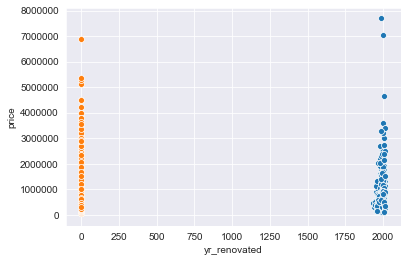

In [7]:
# checking the impact of homes renovated versus not renovated against price

no_reno = df[df['yr_renovated'] == 0]

reno = df[df['yr_renovated'] != 0]

sns.scatterplot(x=reno['yr_renovated'], y=reno['price'])
sns.scatterplot(x=no_reno['yr_renovated'], y=no_reno['price'])

The columns 'yr_renovated' is categorical so we'll alter data frame to represent this.  Renovated homes will be represented by a 1 and non-renovated homes will be represented by a 0. 

In [8]:
for i in range(len(df['yr_renovated'])):
    if df['yr_renovated'].iloc[i] != 0.0:
        df['yr_renovated'].iloc[i] = 1.0
# change name to just renovated
df = df.rename(columns={'yr_renovated' : 'renovated'})

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Judging from this graph, and knowing that the number of non-renovated homes far exceeds the number of renovated homes, I see that whether a home has been renovated or not has 

## View

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64
id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view             63
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
renovated         0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
dtype: int64


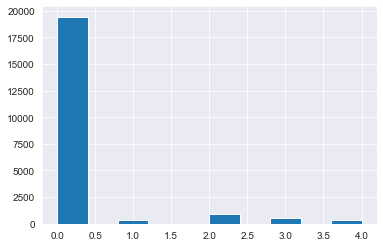

In [10]:
# view column refers to how many times the home has been viewed
print(df.view.value_counts())
print(df.isnull().sum())
df.view.hist()

In [11]:
med_vu = df.view.median()
med_vu

0.0

In [12]:
# Only makes up 0.29% of total data, but the median does not change the 
# create a new category.  Fill with median.
df.fillna(value=med_vu, inplace=True)
df.view.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: view, dtype: float64

## Date

In [13]:
# Time to deal with object types.
import datetime as dt
df.date.head()

0    10/13/2014
1     12/9/2014
2     2/25/2015
3     12/9/2014
4     2/18/2015
Name: date, dtype: object

In [14]:
# convert 'date' to datetime, then creating 2 new columns so that we can work
# with numerical data
df.date = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear


## Sqft_Basement

In [15]:
# inspecting sqft_basement values
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
516.0         1
1798.0        1
2360.0        1
274.0         1
2120.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [16]:
# 452 values of '?'. Makes up 2.1% of our data. 
med_bsmt = df[df['sqft_basement'] != '?']
med = med_bsmt.sqft_basement.median()

for i in range(len(df['sqft_basement'])):
    if df['sqft_basement'].iloc[i] == '?':
        df['sqft_basement'].iloc[i] = str(med)


df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
274.0         1
666.0         1
906.0         1
1920.0        1
2350.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [17]:
# convert to float
df['sqft_basement'] = df.sqft_basement.astype(float)
df.sqft_basement.dtype

dtype('float64')

### Change to Categorical Format

In [18]:
for i in range(len(df['sqft_basement'])):
    if df['sqft_basement'].iloc[i] != 0.0:
        df['sqft_basement'].iloc[i] = 1.0
        
df = df.rename(columns={'sqft_basement' : 'basement'})
df.basement.head()

0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: basement, dtype: float64

## Checking for duplicates

In [19]:
# checking for duplicates
dups = df[df.duplicated(['id'],keep=False)]
dups.groupby('id', axis=1)
dups


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day_of_year
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,1.0,1939,0.0,98117,47.6870,-122.386,1570,4500,7,206
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,1.0,1939,0.0,98117,47.6870,-122.386,1570,4500,12,357
313,4139480200,2014-06-18,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,1.0,1997,0.0,98006,47.5503,-122.102,3860,11244,6,169
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,1.0,1997,0.0,98006,47.5503,-122.102,3860,11244,12,343
324,7520000520,2014-09-05,232000.0,2,1.00,1240,12092,1.0,0.0,0.0,...,1.0,1922,1.0,98146,47.4957,-122.352,1820,7460,9,248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20654,8564860270,2015-03-30,502000.0,4,2.50,2680,5539,2.0,0.0,0.0,...,0.0,2013,0.0,98045,47.4759,-121.734,2680,5992,3,89
20763,6300000226,2014-06-26,240000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,0.0,1933,0.0,98133,47.7076,-122.342,1130,1598,6,177
20764,6300000226,2015-05-04,380000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,0.0,1933,0.0,98133,47.7076,-122.342,1130,1598,5,124
21564,7853420110,2014-10-03,594866.0,3,3.00,2780,6000,2.0,0.0,0.0,...,0.0,2013,0.0,98065,47.5184,-121.886,2850,6000,10,276


In [20]:
# duplicates indicate that the houses were sold more than once. Creating 
# subset  of data to see if duplicates were purchased by house flippers
flips = dups[['id', 'date', 'price', 'condition', 'grade']]
flips.head(20)

,id,date,price,condition,grade
93,6021501535,2014-07-25,430000.0,3,8
94,6021501535,2014-12-23,700000.0,3,8
313,4139480200,2014-06-18,1380000.0,3,11
314,4139480200,2014-12-09,1400000.0,3,11
324,7520000520,2014-09-05,232000.0,3,6
325,7520000520,2015-03-11,240500.0,3,6
345,3969300030,2014-07-23,165000.0,3,6
346,3969300030,2014-12-29,239900.0,3,6
371,2231500030,2014-10-01,315000.0,5,7
372,2231500030,2015-03-24,530000.0,5,7


Houses were bought at lower price and sold later at a higher price, but
**grade and condition stayed the same**. Grade and condition of these homes **did not** play a significant role in the sales of these homes. **Homes may not have been flipped**.

In [21]:
# To prevent noise in our data, will remove duplicates and keeping the most
# most recent sale price

df = df.drop_duplicates(subset='id', keep='last')
df.duplicated(['id']).value_counts()

False    21420
dtype: int64

In [22]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day_of_year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,286
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1.0,1951,1.0,98125,47.7210,-122.319,1690,7639,12,343
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062,2,56
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,343
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,49


In [23]:
# Cleaning done. Creating new CSV file.
df.reset_index()
df.to_csv('csv_files/kc_house_data_clean.csv')

# Exploring the Data
We've done some investigation of the data already, but that was used more as a 
means to clean the data. Now we'll investigate relationships and check for 
correlations and multicollinearity.

In [24]:
rdf = pd.read_csv('csv_files/kc_house_data_clean.csv')
rdf = rdf.drop(columns='Unnamed: 0', axis=1)
rdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day_of_year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,286
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1.0,1951,1.0,98125,47.7210,-122.319,1690,7639,12,343
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062,2,56
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,343
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,49


<Figure size 576x360 with 0 Axes>

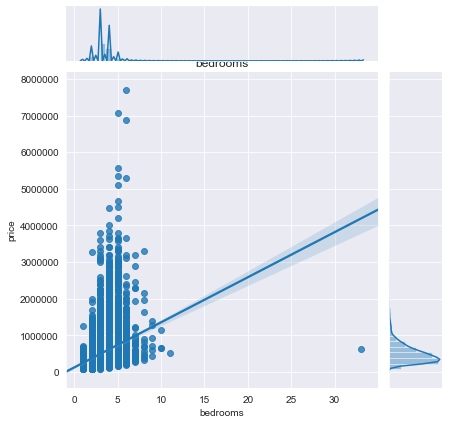

<Figure size 576x360 with 0 Axes>

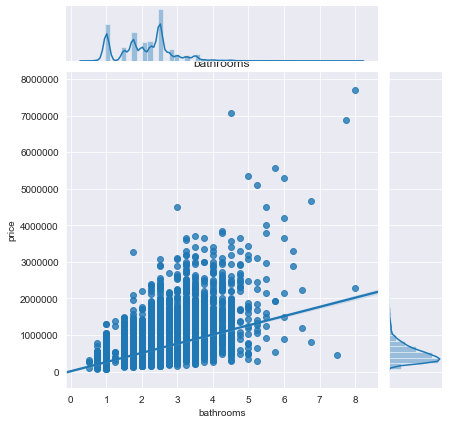

<Figure size 576x360 with 0 Axes>

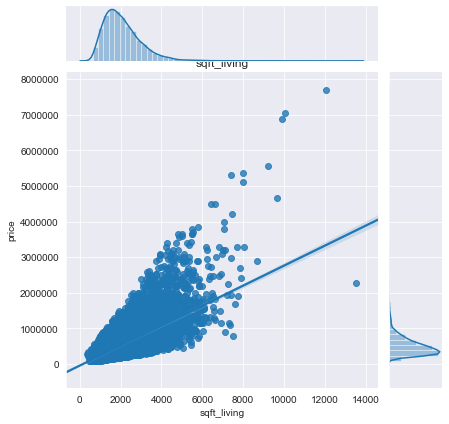

<Figure size 576x360 with 0 Axes>

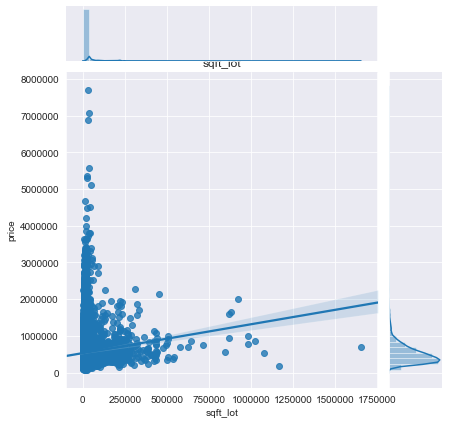

<Figure size 576x360 with 0 Axes>

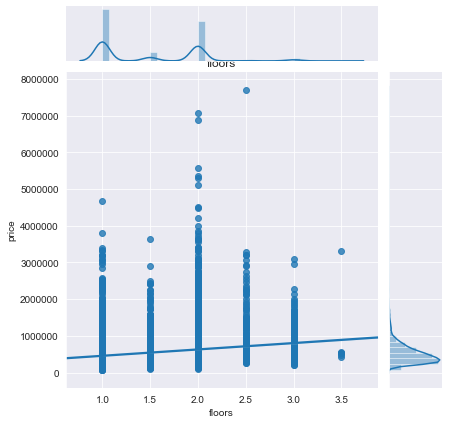

<Figure size 576x360 with 0 Axes>

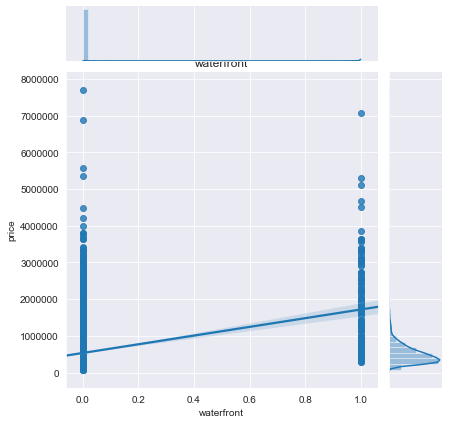

<Figure size 576x360 with 0 Axes>

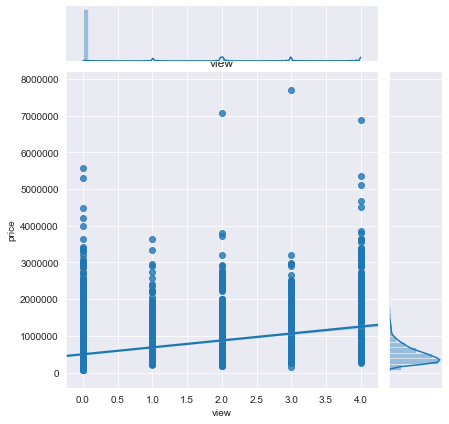

<Figure size 576x360 with 0 Axes>

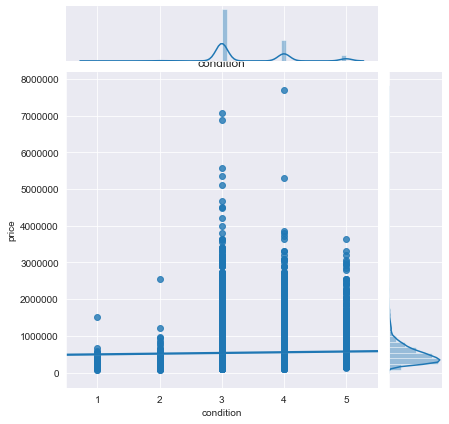

<Figure size 576x360 with 0 Axes>

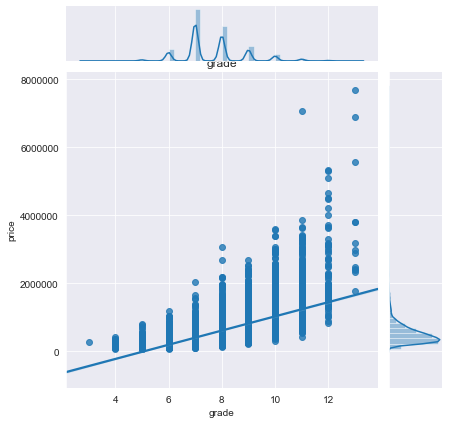

<Figure size 576x360 with 0 Axes>

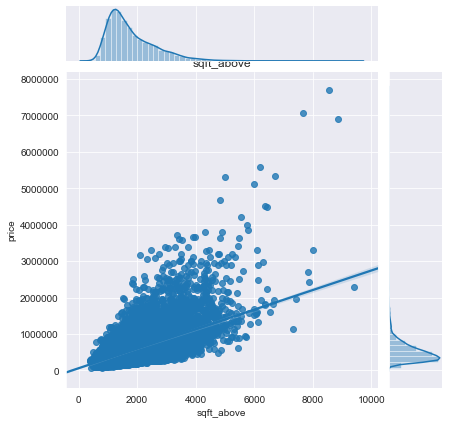

<Figure size 576x360 with 0 Axes>

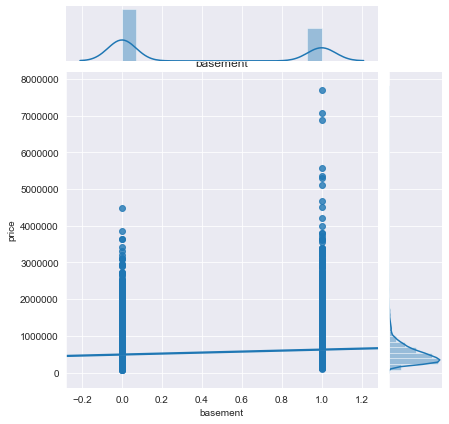

<Figure size 576x360 with 0 Axes>

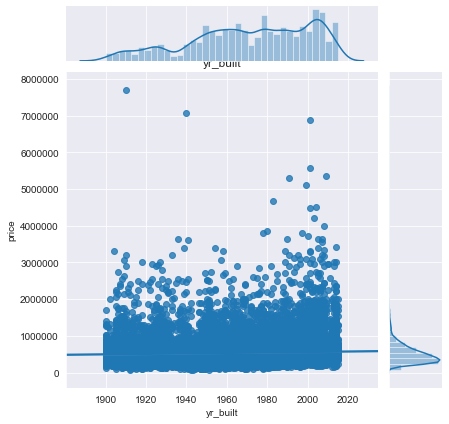

<Figure size 576x360 with 0 Axes>

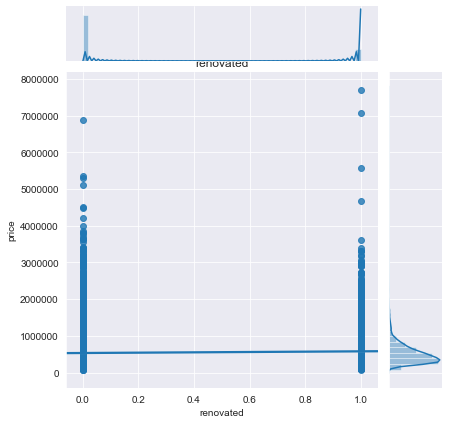

<Figure size 576x360 with 0 Axes>

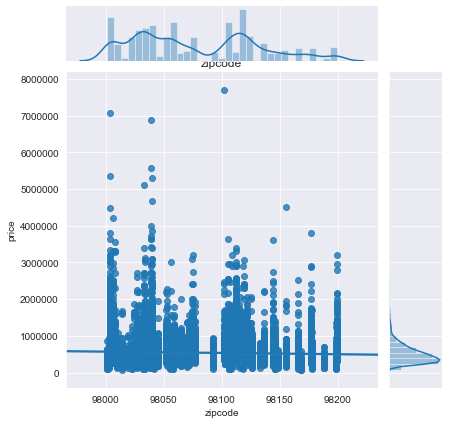

<Figure size 576x360 with 0 Axes>

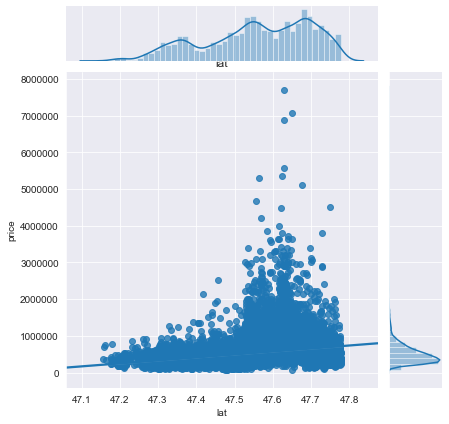

<Figure size 576x360 with 0 Axes>

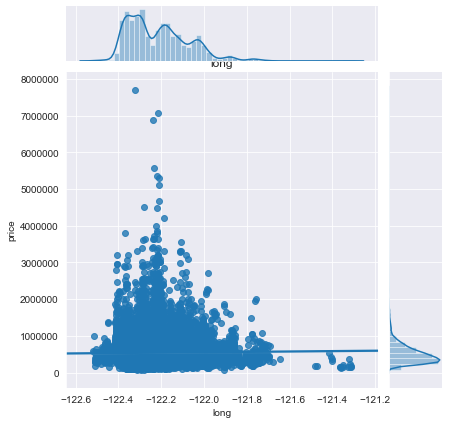

<Figure size 576x360 with 0 Axes>

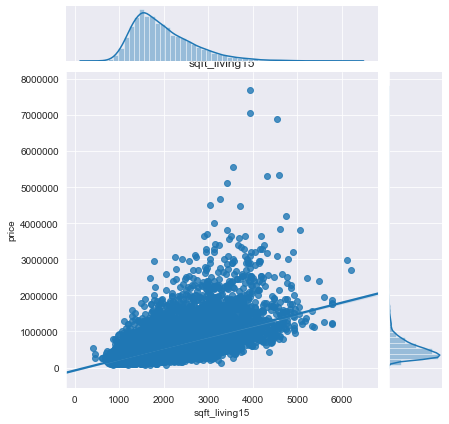

<Figure size 576x360 with 0 Axes>

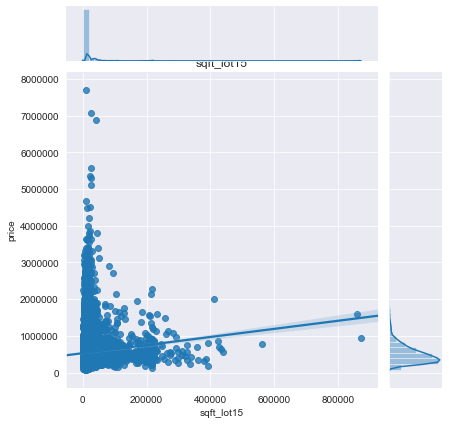

<Figure size 576x360 with 0 Axes>

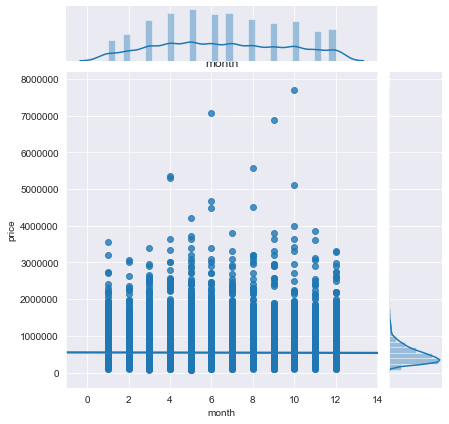

<Figure size 576x360 with 0 Axes>

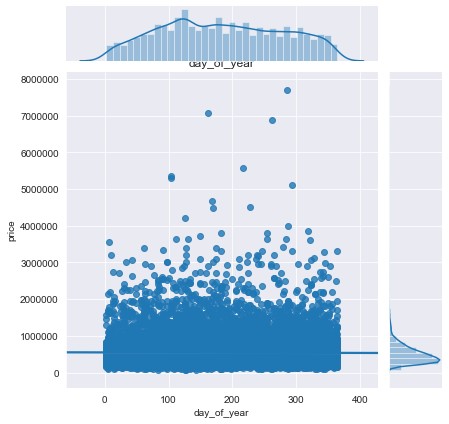

In [25]:
# using for loop to visualize relationship of the different columns to 'price'
no_date = rdf.drop(['date', 'id', 'price'], axis=1)

for col in no_date.columns:
    plt.figure(figsize=(8,5))
    sns.jointplot(x= col, y= 'price', data=rdf, kind='reg')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.show()

Observations: Price is pretty normally distributed.

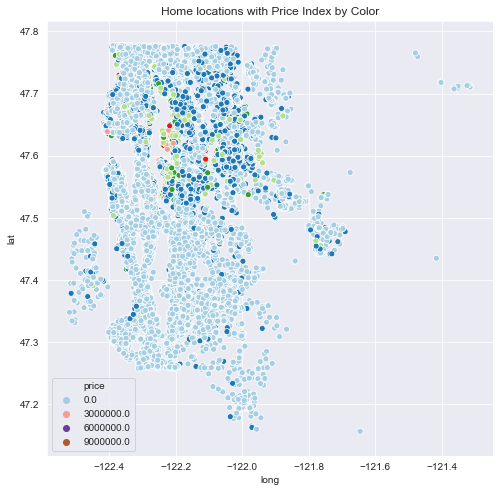

In [26]:
long = rdf['long']
lat = rdf['lat']
plt.figure(figsize=(8,8))
sns.scatterplot(x=long, y=lat, hue='price', data=rdf, palette='Paired')
plt.title('Home locations with Price Index by Color')
plt.legend(fancybox=True)

In [27]:
print(long.describe())
print(lat.describe())

count    21420.000000
mean      -122.213784
std          0.140791
min       -122.519000
25%       -122.328000
50%       -122.230000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64
count    21420.000000
mean        47.560197
std          0.138589
min         47.155900
25%         47.471200
50%         47.572100
75%         47.678100
max         47.777600
Name: lat, dtype: float64


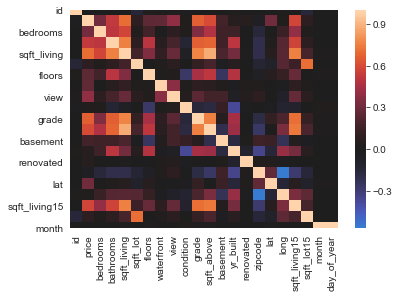

In [28]:
# generating heatmap
sns.heatmap(rdf.corr(), center=0);

In [29]:
# creating a date frame that only contains the pairs of values with highest 
# correlation

# converts all elements to absolute values, stacks into multi-index, resets 
# the index to set the multi-index to seperate columns, and finally sorts them
corr_pairs = rdf.corr().abs().stack().reset_index().sort_values(0, 
                                                                ascending=False)
# zipping the variable name columns
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

#set index to the pairs
pairs_index = corr_pairs.set_index(['pairs'])

#dropping level columns
pairs = pairs_index.drop(columns=['level_0', 'level_1'])

#renaming column for comprehension
pairs.columns = ['correlation']
#Since our heatmap shows that our variables only show perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

In [30]:
unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(day_of_year, month)",0.995842
"(sqft_above, sqft_living)",0.876533
"(sqft_living, grade)",0.762477
"(sqft_above, grade)",0.756221
"(sqft_living15, sqft_living)",0.756186
"(bathrooms, sqft_living)",0.755522


In [31]:
# due to high correlaton of day of the year and  sqft_above, we'll drop these
# columns 

rdf.drop(columns=['sqft_above', 'day_of_year'], inplace=True)

### Initial Observations: 
   * Grade has a linear rather linear relationship to price. May break these up into bins to consolidate dummy variables 
   * Square foot above ground seems to also have a somewhat linear relationship
   * Distributions of longitude and latitude seem to point at areas that have higher land value. 
   * Lot size of the home or nearest neighbors seems to have little effect on price
   * Need to deal with sizes of categorical data.
   * Need to deal with the outliers in continuous variables
   * Is the number of bedrooms actually categorical?
   * High correlation between sqft_above and sqft_living  

## Baseline Model

In [32]:
target = 'price'

feats = rdf.drop(['price', 'date', 'id'], axis=1).columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=rdf).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
==================================================================================
Model:                    OLS                  Adj. R-squared:         0.699      
Dependent Variable:       price                AIC:                    584037.0526
Date:                     2020-07-16 19:32     BIC:                    584188.5222
No. Observations:         21420                Log-Likelihood:         -2.9200e+05
Df Model:                 18                   F-statistic:            2770.      
Df Residuals:             21401                Prob (F-statistic):     0.00       
R-squared:                0.700                Scale:                  4.0607e+10 
----------------------------------------------------------------------------------
                 Coef.       Std.Err.      t     P>|t|     [0.025        0.975]   
----------------------------------------------------------------------------------
Intercept     7491946.7738 2957872.7054   2.5329 0.0113 1694294.9060 13289598.6416
bedrooms       -36477.9087    1913.5273 -19.0632 0.0000  -40228.5654   -32727.2521
bathrooms       44037.5115    3283.5037  13.4117 0.0000   37601.5985    50473.4245
sqft_living       173.6742       3.4148  50.8592 0.0000     166.9810      180.3675
sqft_lot            0.1288       0.0480   2.6826 0.0073       0.0347        0.2228
floors          12061.1705    3472.8559   3.4730 0.0005    5254.1130    18868.2280
waterfront     623761.3442   18155.7308  34.3562 0.0000  588174.7531   659347.9354
view            51889.1162    2113.1131  24.5558 0.0000   47747.2563    56030.9761
condition       24275.9027    2335.9996  10.3921 0.0000   19697.1686    28854.6367
grade           98783.0979    2152.4146  45.8941 0.0000   94564.2042   103001.9916
basement       -18965.0168    3377.0323  -5.6159 0.0000  -25584.2529   -12345.7808
yr_built        -2759.9738      69.8019 -39.5401 0.0000   -2896.7908    -2623.1567
renovated        8189.4785    3403.5728   2.4061 0.0161    1518.2210    14860.7360
zipcode          -584.5297      33.2221 -17.5946 0.0000    -649.6476     -519.4118
lat            598611.7293   10778.5901  55.5371 0.0000  577484.8860   619738.5727
long          -213787.0950   13229.4665 -16.1599 0.0000 -239717.8394  -187856.3506
sqft_living15      22.0592       3.4406   6.4114 0.0000      15.3153       28.8031
sqft_lot15         -0.3797       0.0735  -5.1654 0.0000      -0.5237       -0.2356
month           -3031.5885     442.0661  -6.8578 0.0000   -3898.0711    -2165.1059
----------------------------------------------------------------------------------
Omnibus:                 18251.037          Durbin-Watson:             1.994      
Prob(Omnibus):           0.000              Jarque-Bera (JB):          1850005.322
Skew:                    3.577              Prob(JB):                  0.000      
Kurtosis:                47.963             Condition No.:             216199304  
==================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

 Kurtosis is extremely high.  High standard error. Have not made dummies or finished binning the
 categorical data, but this is a good start.

### Formating Additional Categorical Data
It's time to address the categorical data that we haven't yet formatted
into friendlier sizes so that our model 

#### Zip Codes

In [33]:
zips = len(rdf['zipcode'].unique())
zips

70

In [34]:
# 70 different zipcodes. Need to group these preferably into 6 sectors
df_test = rdf.copy()

In [35]:
df_test.loc[(df_test['lat'] > 47.5) & (df_test['long'] < -121.9), 
            "quad_1"] = 1

In [36]:
df_test.quad_1.value_counts()

1.0    14480
Name: quad_1, dtype: int64

In [37]:

df_test.loc[(df_test['lat'] >= 47.5) & (df_test['long'] >= -121.9), 
            "quad_2"] = 1
df_test.loc[(df_test['lat'] < 47.5) & (df_test['long'] < -121.9), 
            "quad_3"] = 1
df_test.loc[(df_test['lat'] < 47.5) & (df_test['long'] > -121.9), 
            "quad_4"] = 1

In [38]:
df_test = df_test.fillna(value=0)
print(df_test.shape)
df_test.head()

(21420, 25)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,quad_1,quad_2,quad_3,quad_4
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,98178,47.5112,-122.257,1340,5650,10,1.0,0.0,0.0,0.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,12,1.0,0.0,0.0,0.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,2,1.0,0.0,0.0,0.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,12,1.0,0.0,0.0,0.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,2,1.0,0.0,0.0,0.0


In [39]:
# Apply to rdf
rdf.loc[(rdf['lat'] > 47.5) & (df_test['long'] < -121.9), 
            "quad_1"] = 1
rdf.loc[(rdf['lat'] >= 47.5) & (df_test['long'] >= -121.9), 
            "quad_2"] = 1
rdf.loc[(rdf['lat'] < 47.5) & (df_test['long'] < -121.9), 
            "quad_3"] = 1
rdf.loc[(rdf['lat'] < 47.5) & (df_test['long'] > -121.9), 
            "quad_4"] = 1

In [40]:
rdf = rdf.fillna(value=0)
print(rdf.shape)
rdf.head()

(21420, 25)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,quad_1,quad_2,quad_3,quad_4
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,98178,47.5112,-122.257,1340,5650,10,1.0,0.0,0.0,0.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,12,1.0,0.0,0.0,0.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,2,1.0,0.0,0.0,0.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,12,1.0,0.0,0.0,0.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,2,1.0,0.0,0.0,0.0


In [41]:
# Now we can drop the zipcode column
rdf1 = rdf.drop(columns=['zipcode'])

#### Grade

In [42]:
rdf1['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

Unique values are 3-13.  If we bin by every 3 numbers, we'll lose value 13 Creating bins are based on odd numbers, we'll be able to account for all of
the values

Text(0, 0.5, 'value counts')

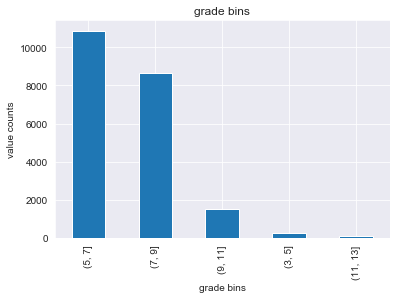

In [43]:
bins = [3, 5, 7, 9, 11, 13]
bin_grd = pd.cut(rdf1['grade'], bins)
bin_grd = bin_grd.cat.as_ordered()

bin_grd.value_counts().plot(kind='bar')
plt.title('grade bins')
plt.xlabel('grade bins')
plt.ylabel('value counts')

In [44]:
# now to afix this to our data frame and create dummies
rdf1['grade'] = bin_grd
rdf1['grade'] = rdf1['grade'].cat.codes
# Creating dummies
gbin_dummies = pd.get_dummies(bin_grd, prefix='grade') #keeping first column 
                                                # so future names make sense

adf = rdf.drop(['id', 'grade'], axis=1)
adf = pd.concat([rdf, gbin_dummies], axis=1)
adf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,month,quad_1,quad_2,quad_3,quad_4,"grade_(3, 5]","grade_(5, 7]","grade_(7, 9]","grade_(9, 11]","grade_(11, 13]"
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,10,1.0,0.0,0.0,0.0,0,1,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,12,1.0,0.0,0.0,0.0,0,1,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,2,1.0,0.0,0.0,0.0,0,1,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,12,1.0,0.0,0.0,0.0,0,1,0,0,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,2,1.0,0.0,0.0,0.0,0,0,1,0,0


Those names are annoying, so we'll rename and simplify them for easier reference

In [45]:
adf1 = adf.rename(columns={'grade_(3, 5]':'grd_F', 'grade_(5, 7]':'grd_D', 
                           'grade_(7, 9]':'grd_C', 'grade_(9, 11]':'grd_B', 
                           'grade_(11, 13]':'grd_A'})
adf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 30 columns):
id               21420 non-null int64
date             21420 non-null object
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       21420 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
basement         21420 non-null float64
yr_built         21420 non-null int64
renovated        21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
month            21420 non-null int64
quad_1           21420 non-null float64
quad_2           21420 non-null fl

In [46]:
# Fixing Dummy Types
for col in adf1.columns:
    if adf1[col].dtype == adf1['grd_A'].dtype:
        adf1[col] = adf1[col].astype(int)
adf1['grd_B'].dtype
    

dtype('int32')

In [47]:
# Let's just drop 'grade' and 'date' now

adf1.drop(['grade', 'date'], axis=1, inplace=True)

In [48]:
target = 'price'

feats = adf1.drop(['price', 'id', 'grd_F'], axis=1).columns

preds = '+'.join(feats)

formula1 = target + '~' + preds
model1 = smf.ols(formula=formula1, data=adf1).fit()
model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.725      
Dependent Variable:      price                 AIC:                     582130.5110
Date:                    2020-07-16 19:32      BIC:                     582337.7851
No. Observations:        21420                 Log-Likelihood:          -2.9104e+05
Df Model:                25                    F-statistic:             2261.      
Df Residuals:            21394                 Prob (F-statistic):      0.00       
R-squared:               0.725                 Scale:                   3.7137e+10 
-----------------------------------------------------------------------------------
                  Coef.       Std.Err.      t     P>|t|     [0.025        0.975]   
-----------------------------------------------------------------------------------
Intercept     14599720.6166 2873846.7293   5.0802 0.0000 8966765.8461 20232675.3870
bedrooms        -24800.1197    1857.7391 -13.3496 0.0000  -28441.4275   -21158.8119
bathrooms        44522.4282    3143.5112  14.1633 0.0000   38360.9108    50683.9455
sqft_living        169.5163       3.2744  51.7699 0.0000     163.0982      175.9344
sqft_lot             0.1537       0.0459   3.3453 0.0008       0.0636        0.2438
floors           17436.9087    3389.2168   5.1448 0.0000   10793.7900    24080.0274
waterfront      608848.1871   17389.4524  35.0125 0.0000  574763.5584   642932.8158
view             47654.5024    2030.0228  23.4749 0.0000   43675.5058    51633.4991
condition        30814.0727    2239.5735  13.7589 0.0000   26424.3410    35203.8044
basement        -19284.1784    3281.3022  -5.8770 0.0000  -25715.7763   -12852.5804
yr_built         -1815.8102      67.5403 -26.8849 0.0000   -1948.1941    -1683.4262
renovated        13464.3778    3256.5361   4.1346 0.0000    7081.3232    19847.4324
zipcode           -551.1099      32.7414 -16.8322 0.0000    -615.2854     -486.9344
lat             171440.8781   18032.1003   9.5075 0.0000  136096.6113   206785.1449
long           -284530.4078   14965.3124 -19.0127 0.0000 -313863.5406  -255197.2751
sqft_living15       43.1035       3.2739  13.1657 0.0000      36.6864       49.5207
sqft_lot15          -0.2965       0.0704  -4.2145 0.0000      -0.4345       -0.1586
month            -2881.9884     422.8401  -6.8158 0.0000   -3710.7866    -2053.1902
quad_1           59648.6168   96495.9574   0.6181 0.5365 -129490.6849   248787.9186
quad_2           24230.6397   96994.3635   0.2498 0.8027 -165885.5754   214346.8547
quad_3         -116741.4501   96476.3343  -1.2101 0.2263 -305842.2891    72359.3890
quad_4           69953.1083   97489.3907   0.7175 0.4730 -121133.3970   261039.6136
grd_D            19388.8172   12312.0232   1.5748 0.1153   -4743.6701    43521.3045
grd_C            76482.2814   12886.6029   5.9350 0.0000   51223.5748   101740.9881
grd_B           309755.2248   14768.2529  20.9744 0.0000  280808.3433   338702.1063
grd_A          1021787.8682   25290.9535  40.4013 0.0000  972215.7058  1071360.0307
-----------------------------------------------------------------------------------
Omnibus:                  16134.912          Durbin-Watson:             1.990      
Prob(Omnibus):            0.000              Jarque-Bera (JB):          1261477.862
Skew:                     2.992              Prob(JB):                  0.000      
Kurtosis:                 40.116             Condition No.:             219654162  
===================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

Observations: R2 went up a touch, kurtosis dropped significantly. 
Dummy Variables have a very positive effect on price if we drop homes with an F grade.

Try new model

In [49]:
# This time we're dropping 'grd_A'
target = 'price'

feats = adf1.drop(['price', 'id', 'grd_A'], axis=1).columns

preds = '+'.join(feats)

formula1 = target + '~' + preds
model1 = smf.ols(formula=formula1, data=adf1).fit()
model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
====================================================================================
Model:                    OLS                   Adj. R-squared:          0.725      
Dependent Variable:       price                 AIC:                     582149.3598
Date:                     2020-07-16 19:32      BIC:                     582356.6339
No. Observations:         21420                 Log-Likelihood:          -2.9105e+05
Df Model:                 25                    F-statistic:             2258.      
Df Residuals:             21394                 Prob (F-statistic):      0.00       
R-squared:                0.725                 Scale:                   3.7169e+10 
------------------------------------------------------------------------------------
                  Coef.       Std.Err.      t     P>|t|      [0.025        0.975]   
------------------------------------------------------------------------------------
Intercept     15367845.4586 2876057.0963   5.3434 0.0000  9730558.2034 21005132.7138
bedrooms        -24799.9734    1858.6754 -13.3428 0.0000   -28443.1164   -21156.8303
bathrooms        44568.7689    3144.8767  14.1719 0.0000    38404.5751    50732.9627
sqft_living        170.0258       3.2738  51.9345 0.0000      163.6088      176.4428
sqft_lot             0.1545       0.0460   3.3602 0.0008        0.0644        0.2446
floors           17326.9180    3390.6888   5.1101 0.0000    10680.9141    23972.9220
waterfront      609111.4987   17397.0268  35.0124 0.0000   575012.0236   643210.9738
view             47702.7247    2030.8909  23.4886 0.0000    43722.0264    51683.4229
condition        30640.5725    2240.5602  13.6754 0.0000    26248.9068    35032.2382
basement        -19479.5468    3282.5070  -5.9344 0.0000   -25913.5062   -13045.5873
yr_built         -1809.8420      67.5598 -26.7887 0.0000    -1942.2643    -1677.4197
renovated        13523.2546    3257.9734   4.1508 0.0000     7137.3829    19909.1263
zipcode           -551.6823      32.7557 -16.8423 0.0000     -615.8860     -487.4786
lat             172597.3785   18040.7498   9.5671 0.0000   137236.1581   207958.5989
long           -286426.5273   14968.7484 -19.1350 0.0000  -315766.3949  -257086.6597
sqft_living15       43.2416       3.2752  13.2026 0.0000       36.8219       49.6613
sqft_lot15          -0.2962       0.0704  -4.2072 0.0000       -0.4341       -0.1582
month            -2861.9113     423.0309  -6.7653 0.0000    -3691.0836    -2032.7391
quad_1           59394.3812   96538.6289   0.6152 0.5384  -129828.5598   248617.3222
quad_2           24277.7807   97037.0844   0.2502 0.8024  -165922.1705   214477.7318
quad_3         -117012.2875   96518.9175  -1.2123 0.2254  -306196.5926    72172.0177
quad_4           70534.0728   97532.2110   0.7232 0.4696  -120636.3635   261704.5092
grd_F         -1010724.3050   25173.7791 -40.1499 0.0000 -1060066.7969  -961381.8131
grd_D          -991269.2334   21575.7716 -45.9436 0.0000 -1033559.3612  -948979.1057
grd_C          -934779.4295   20811.7489 -44.9159 0.0000  -975572.0156  -893986.8435
grd_B          -702395.9637   20305.1489 -34.5920 0.0000  -742195.5758  -662596.3515
------------------------------------------------------------------------------------
Omnibus:                 16141.287           Durbin-Watson:              1.990      
Prob(Omnibus):           0.000               Jarque-Bera (JB):           1263427.862
Skew:                    2.993               Prob(JB):                   0.000      
Kurtosis:                40.145              Condition No.:              219726400  
====================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

When you drop grade A homes (which were mostly outliers, similar to F grade homes) the effect is much more negative across the board for the dummy variables.

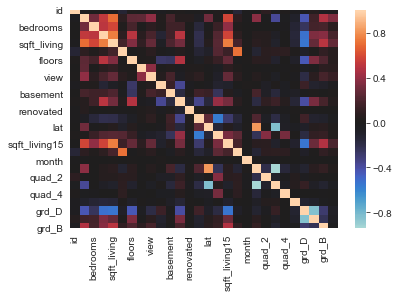

In [50]:
# Checking for correlation with the new dummy columns
sns.heatmap(data=adf1.corr(), center=0)

In [51]:
# Rechecking correlated values
corr_pairs = adf1.corr().abs().stack().reset_index().sort_values(0,
                                                            ascending=False)
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

pairs_index = corr_pairs.set_index(['pairs'])

pairs = pairs_index.drop(columns=['level_0', 'level_1'])

pairs.columns = ['correlation']
#heatmap still shows that our variables only have perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

In [52]:
unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(quad_3, quad_1)",0.934385
"(grd_D, grd_C)",0.836263
"(lat, quad_3)",0.826516
"(lat, quad_1)",0.821455
"(sqft_living15, sqft_living)",0.756186
"(bathrooms, sqft_living)",0.755522


<Figure size 576x360 with 0 Axes>

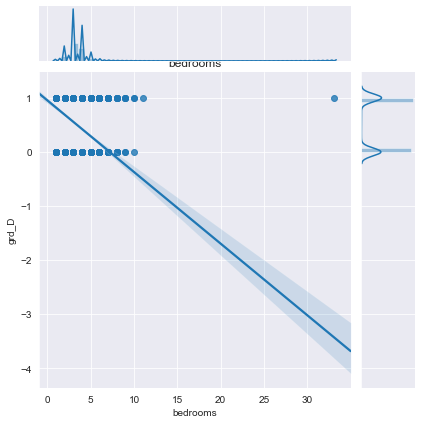

<Figure size 576x360 with 0 Axes>

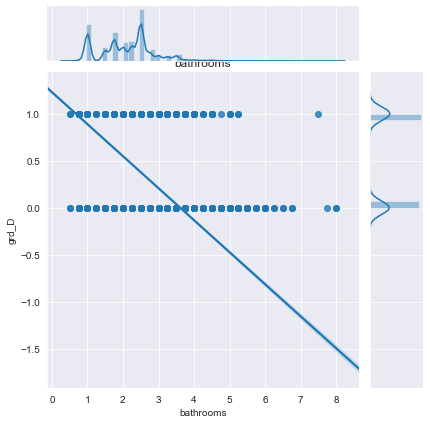

<Figure size 576x360 with 0 Axes>

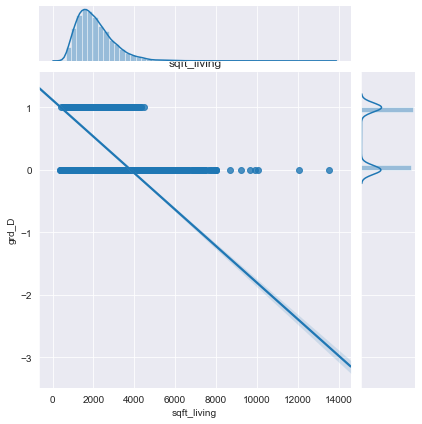

<Figure size 576x360 with 0 Axes>

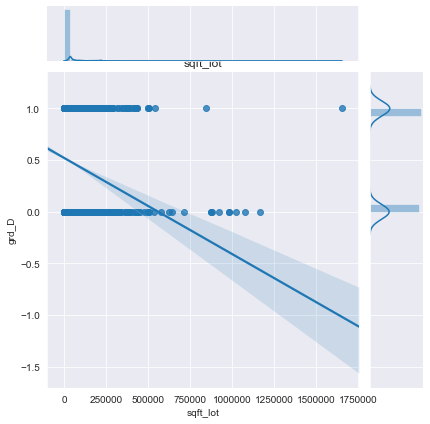

<Figure size 576x360 with 0 Axes>

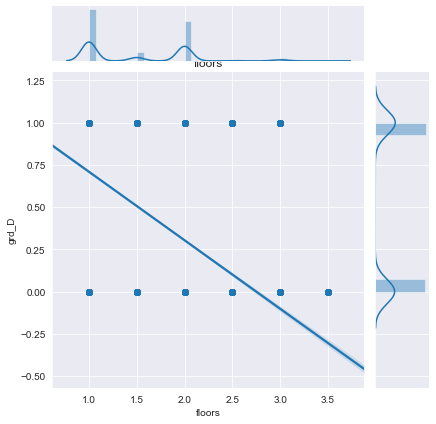

<Figure size 576x360 with 0 Axes>

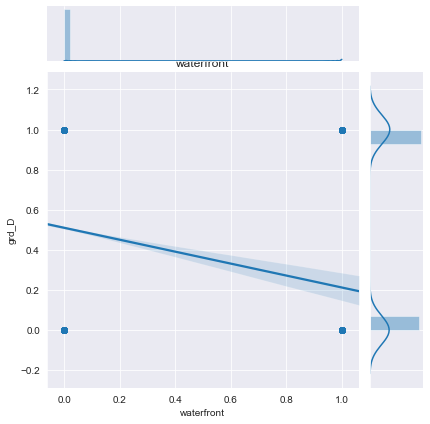

<Figure size 576x360 with 0 Axes>

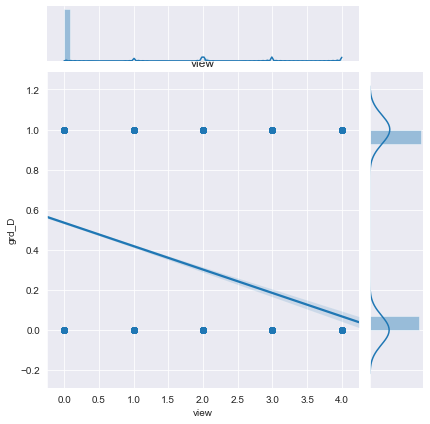

<Figure size 576x360 with 0 Axes>

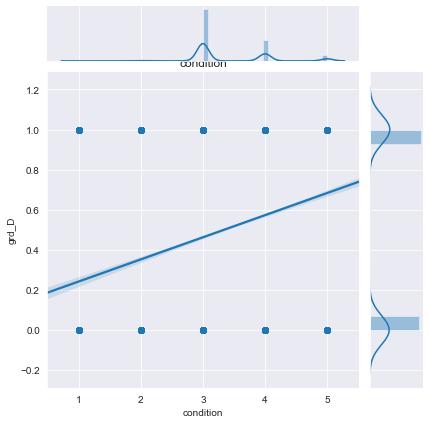

<Figure size 576x360 with 0 Axes>

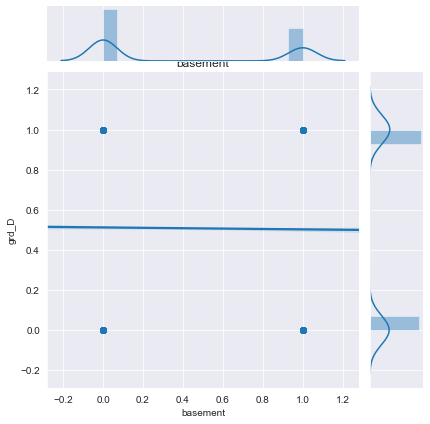

<Figure size 576x360 with 0 Axes>

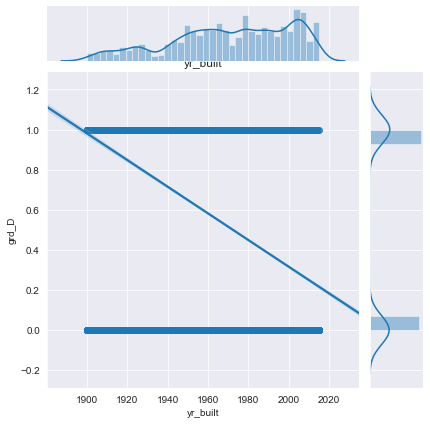

<Figure size 576x360 with 0 Axes>

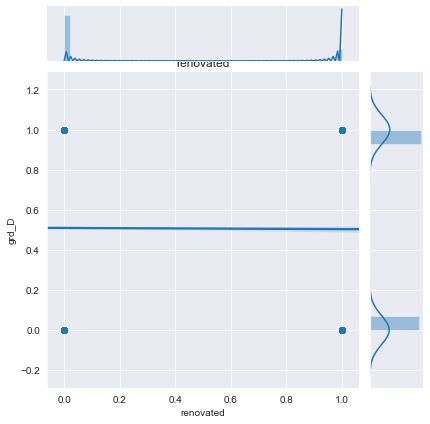

<Figure size 576x360 with 0 Axes>

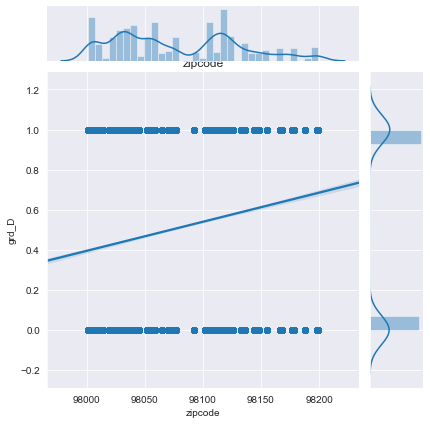

<Figure size 576x360 with 0 Axes>

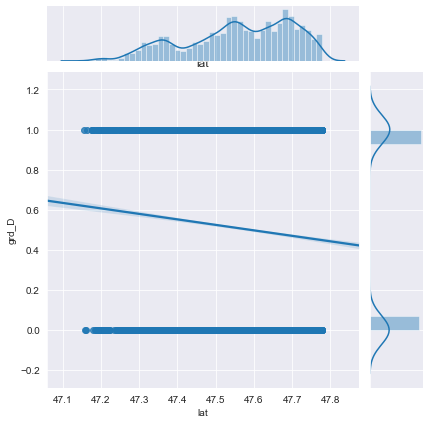

<Figure size 576x360 with 0 Axes>

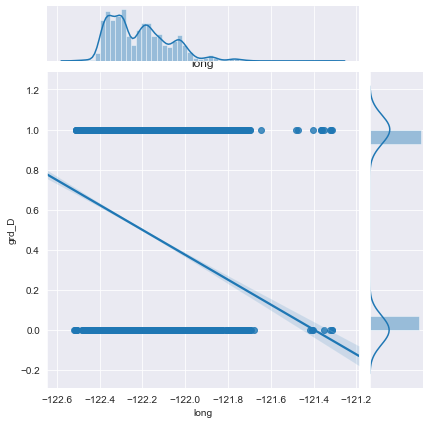

<Figure size 576x360 with 0 Axes>

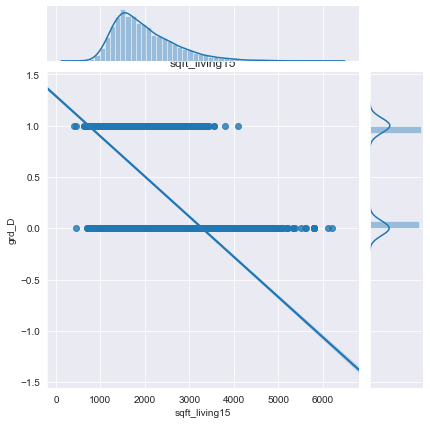

<Figure size 576x360 with 0 Axes>

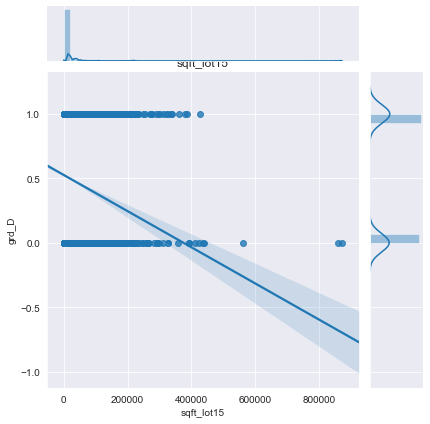

<Figure size 576x360 with 0 Axes>

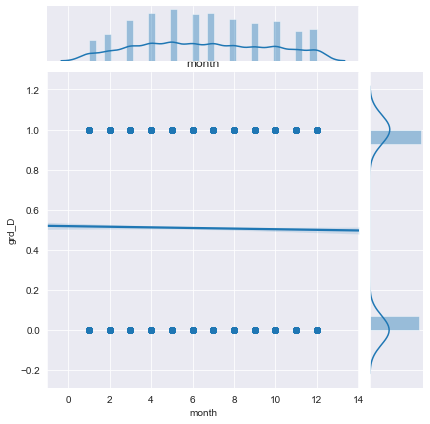

<Figure size 576x360 with 0 Axes>

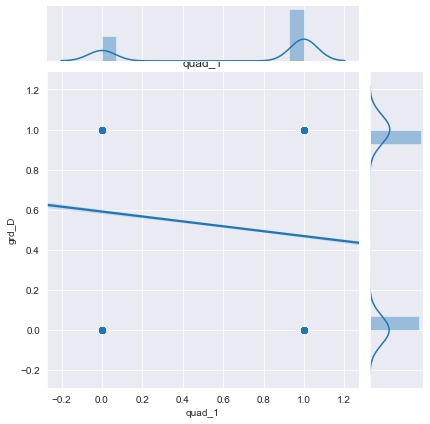

<Figure size 576x360 with 0 Axes>

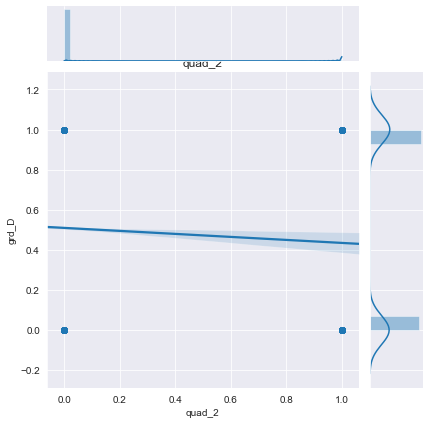

<Figure size 576x360 with 0 Axes>

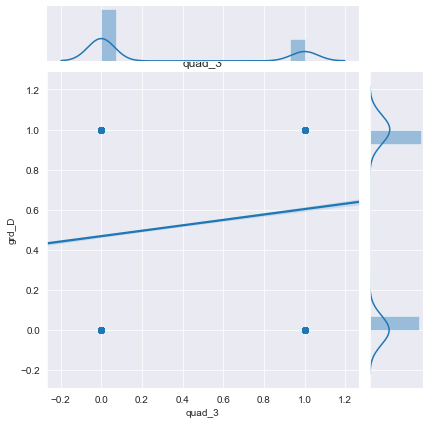

<Figure size 576x360 with 0 Axes>

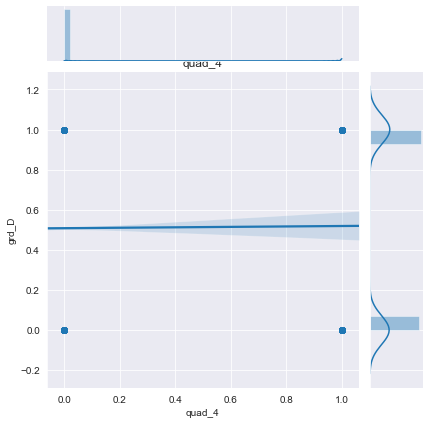

<Figure size 576x360 with 0 Axes>

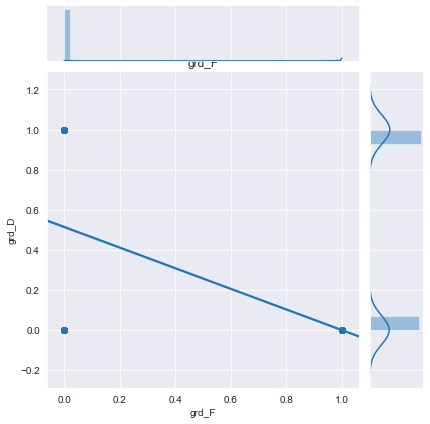

<Figure size 576x360 with 0 Axes>

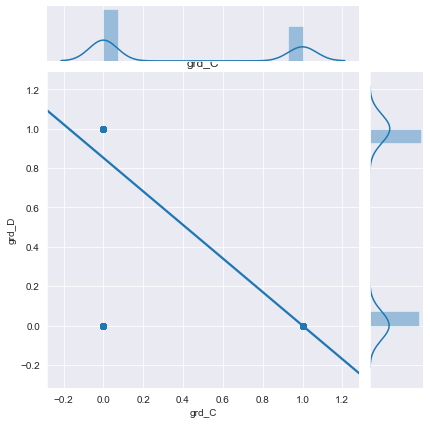

<Figure size 576x360 with 0 Axes>

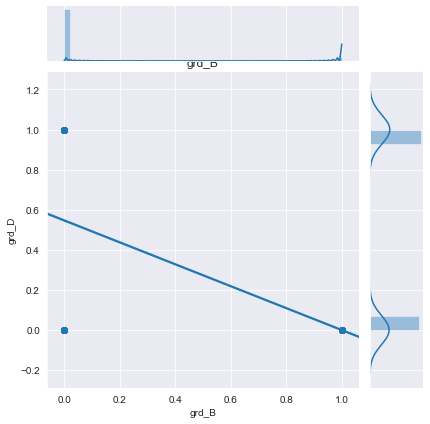

<Figure size 576x360 with 0 Axes>

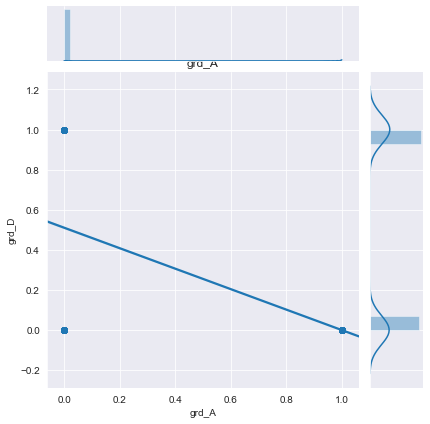

In [53]:
#according to heatmap, grd_D and quad_1 have high influence in a lot of areas.
no_d = adf1.drop(['id', 'price', 'grd_D'], axis=1)

for col in no_d.columns:
    plt.figure(figsize=(8,5))
    sns.jointplot(x= col, y= 'grd_D', data=adf1, kind='reg')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('grd_D')
    plt.show()

In [54]:
# Since one of the dummy vars needs to be dropped and grd_D influences the
# most features, we'll drop grd_D and quad_1 from now on

target = 'price'

feats = adf1.drop(['price', 'id', 'grd_D', 'quad_1'], axis=1).columns

preds = '+'.join(feats)

formula1 = target + '~' + preds
model1 = smf.ols(formula=formula1, data=adf1).fit()
model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.725      
Dependent Variable:      price                 AIC:                     582128.7285
Date:                    2020-07-16 19:33      BIC:                     582328.0305
No. Observations:        21420                 Log-Likelihood:          -2.9104e+05
Df Model:                24                    F-statistic:             2355.      
Df Residuals:            21395                 Prob (F-statistic):      0.00       
R-squared:               0.725                 Scale:                   3.7135e+10 
-----------------------------------------------------------------------------------
                  Coef.       Std.Err.      t     P>|t|     [0.025        0.975]   
-----------------------------------------------------------------------------------
Intercept     14689450.9909 2872351.1261   5.1141 0.0000 9059427.7296 20319474.2522
bedrooms        -24808.5180    1857.6001 -13.3551 0.0000  -28449.5533   -21167.4827
bathrooms        44520.3681    3143.4532  14.1629 0.0000   38358.9646    50681.7717
sqft_living        169.5161       3.2743  51.7713 0.0000     163.0981      175.9340
sqft_lot             0.1538       0.0459   3.3471 0.0008       0.0637        0.2438
floors           17455.4644    3389.0023   5.1506 0.0000   10812.7661    24098.1627
waterfront      608852.7926   17389.1406  35.0134 0.0000  574768.7751   642936.8101
view             47660.0131    2029.9746  23.4781 0.0000   43681.1108    51638.9154
condition        30809.2907    2239.5959  13.7566 0.0000   26419.5151    35199.0664
basement        -19268.2001    3281.0735  -5.8725 0.0000  -25699.3499   -12837.0503
yr_built         -1816.4867      67.5312 -26.8985 0.0000   -1948.8528    -1684.1206
renovated        13428.0806    3255.9177   4.1242 0.0000    7046.2382    19809.9231
zipcode           -551.4303      32.7376 -16.8440 0.0000    -615.5984     -487.2623
lat             171790.4421   18024.2268   9.5311 0.0000  136461.6081   207119.2762
long           -284574.7969   14963.9051 -19.0174 0.0000 -313905.1712  -255244.4225
sqft_living15       43.1042       3.2739  13.1661 0.0000      36.6872       49.5213
sqft_lot15          -0.2971       0.0704  -4.2227 0.0000      -0.4350       -0.1592
month            -2881.8574     422.8318  -6.8156 0.0000   -3710.6395    -2053.0754
quad_2          -35306.5989   11048.8634  -3.1955 0.0014  -56963.1985   -13649.9994
quad_3         -176264.3845    5570.4207 -31.6429 0.0000 -187182.8261  -165345.9428
quad_4           10418.8790   15082.2119   0.6908 0.4897  -19143.3855    39981.1436
grd_F           -20266.9571   12326.8248  -1.6441 0.1002  -44428.4566     3894.5423
grd_C            57097.0535    3668.7233  15.5632 0.0000   49906.0811    64288.0259
grd_B           290393.2594    7640.4698  38.0073 0.0000  275417.3664   305369.1523
grd_A          1002431.7186   21711.2396  46.1711 0.0000  959876.0634  1044987.3738
-----------------------------------------------------------------------------------
Omnibus:                  16134.566          Durbin-Watson:             1.990      
Prob(Omnibus):            0.000              Jarque-Bera (JB):          1261369.746
Skew:                     2.992              Prob(JB):                  0.000      
Kurtosis:                 40.115             Condition No.:             219542811  
===================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

Dropping grd_D resulted in our dummy variables having less fluctuation.

#### Months

In [55]:
# Don't want 12 dummy variables for months. Binning according to 4 seasons
bins = [0, 3, 6, 9, 12]
b_mnth = pd.cut(adf1['month'], bins)
b_mnth = b_mnth.cat.as_ordered()
b_mnth.head()

0    (9, 12]
1    (9, 12]
2     (0, 3]
3    (9, 12]
4     (0, 3]
Name: month, dtype: category
Categories (4, interval[int64]): [(0, 3] < (3, 6] < (6, 9] < (9, 12]]

Text(0.5, 1.0, 'Month Bins')

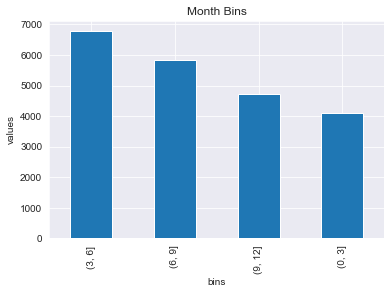

In [56]:
# Looks alright so far, lets plot and check see distribution
b_mnth.value_counts().plot(kind='bar')
plt.xlabel('bins')
plt.ylabel('values')
plt.title('Month Bins')


In [57]:
# Ok, as expected, between fall and spring you see a drop in sales. 
# Making dummies

adf1['month']= b_mnth
adf1['month'] = adf1['month'].cat.codes
mnth_dummies = pd.get_dummies(b_mnth, prefix='season')
adf1 = adf1.drop(['month'], axis=1)
adf1 = pd.concat([adf1, mnth_dummies], axis=1)
adf1.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,quad_4,grd_F,grd_D,grd_C,grd_B,grd_A,"season_(0, 3]","season_(3, 6]","season_(6, 9]","season_(9, 12]"
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0.0,0,1,0,0,0,0,0,0,1
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,0.0,0,1,0,0,0,0,0,0,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0.0,0,1,0,0,0,1,0,0,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,0.0,0,1,0,0,0,0,0,0,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0.0,0,0,1,0,0,1,0,0,0


In [58]:
# renaming columns for clarity

adf2 = adf1.rename(columns={'season_(0, 3]':'wntr_spr', 
                            'season_(3, 6]':'spr_summ', 
                            'season_(6, 9]':'summ_fall', 
                            'season_(9, 12]':'fall_wntr'})

In [59]:
#checking change and data types of new dummies

adf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 31 columns):
id               21420 non-null int64
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       21420 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
basement         21420 non-null float64
yr_built         21420 non-null int64
renovated        21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
quad_1           21420 non-null float64
quad_2           21420 non-null float64
quad_3           21420 non-null float64
quad_4           21420 non-null float64
grd_F            21420 non-nu

In [60]:
# converting dummy vars' data types
for col in adf2.columns:
    if adf2[col].dtype == adf2['fall_wntr'].dtype:
        adf2[col] = adf2[col].astype(int)
adf2['wntr_spr'].dtype

dtype('int32')

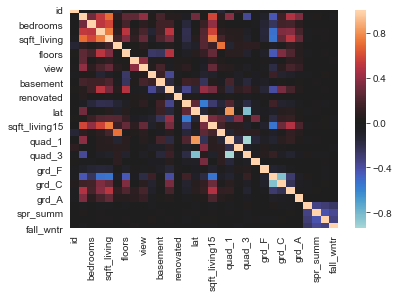

In [61]:
# checking heatmap for new correlations 
sns.heatmap(data=adf2.corr(), center=0)

In [62]:
# Looks safe, they only correlate to eachother, drop the first one: 'wntr_spr'
target = 'price'

feats = adf2.drop(['price', 'id', 'grd_D', 'wntr_spr'], axis=1).columns

preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=adf2).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.725      
Dependent Variable:      price                 AIC:                     582127.5146
Date:                    2020-07-16 19:33      BIC:                     582350.7329
No. Observations:        21420                 Log-Likelihood:          -2.9104e+05
Df Model:                27                    F-statistic:             2094.      
Df Residuals:            21392                 Prob (F-statistic):      0.00       
R-squared:               0.726                 Scale:                   3.7128e+10 
-----------------------------------------------------------------------------------
                  Coef.       Std.Err.      t     P>|t|     [0.025        0.975]   
-----------------------------------------------------------------------------------
Intercept     14765928.1759 2874395.8797   5.1371 0.0000 9131896.9998 20399959.3520
bedrooms        -24853.6403    1857.5952 -13.3795 0.0000  -28494.6660   -21212.6145
bathrooms        44511.9419    3143.3837  14.1605 0.0000   38350.6744    50673.2094
sqft_living        169.5799       3.2743  51.7920 0.0000     163.1621      175.9977
sqft_lot             0.1538       0.0459   3.3469 0.0008       0.0637        0.2438
floors           17399.2010    3388.9165   5.1341 0.0000   10756.6708    24041.7312
waterfront      608379.7406   17388.4319  34.9876 0.0000  574297.1119   642462.3692
view             47694.1014    2030.0373  23.4942 0.0000   43715.0763    51673.1266
condition        30853.7541    2241.0361  13.7676 0.0000   26461.1554    35246.3528
basement        -19460.2213    3281.2391  -5.9308 0.0000  -25891.6957   -13028.7470
yr_built         -1814.9145      67.5281 -26.8764 0.0000   -1947.2747    -1682.5544
renovated        13473.2306    3256.2416   4.1377 0.0000    7090.7532    19855.7080
zipcode           -551.9757      32.7414 -16.8586 0.0000    -616.1513     -487.8000
lat             171030.1391   18029.9334   9.4859 0.0000  135690.1193   206370.1588
long           -284140.2287   14963.9313 -18.9883 0.0000 -313470.6547  -254809.8028
sqft_living15       43.0872       3.2740  13.1603 0.0000      36.6699       49.5046
sqft_lot15          -0.2990       0.0704  -4.2499 0.0000      -0.4369       -0.1611
quad_1           55233.8401   96496.7854   0.5724 0.5671 -133907.0856   244374.7658
quad_2           19730.0569   96995.1958   0.2034 0.8388 -170387.7904   209847.9043
quad_3         -121268.0417   96477.8027  -1.2570 0.2088 -310371.7599    67835.6766
quad_4           65595.4932   97488.5744   0.6729 0.5010 -125489.4132   256680.3996
grd_F           -20121.7809   12331.6814  -1.6317 0.1028  -44292.7998     4049.2380
grd_C            57142.5763    3668.7565  15.5755 0.0000   49951.5388    64333.6139
grd_B           290076.8000    7640.5750  37.9653 0.0000  275100.7007   305052.8993
grd_A          1003058.8883   21709.0977  46.2045 0.0000  960507.4311  1045610.3456
spr_summ         -2170.1871    3822.7931  -0.5677 0.5702   -9663.1477     5322.7736
summ_fall       -20108.7350    3937.9542  -5.1064 0.0000  -27827.4201   -12390.0499
fall_wntr       -21048.5942    4123.8450  -5.1041 0.0000  -29131.6393   -12965.5492
-----------------------------------------------------------------------------------
Omnibus:                  16129.844          Durbin-Watson:             1.991      
Prob(Omnibus):            0.000              Jarque-Bera (JB):          1259514.018
Skew:                     2.991              Prob(JB):                  0.000      
Kurtosis:                 40.087             Condition No.:             219721722  
===================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numeri

#### Condition 

In [63]:
# Getting dummies for condition 
cond_dummies = pd.get_dummies(adf2['condition'], prefix='cond')

In [64]:
adf3 = pd.concat([adf2, cond_dummies], axis=1)

In [65]:
adf3.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,grd_A,wntr_spr,spr_summ,summ_fall,fall_wntr,cond_1,cond_2,cond_3,cond_4,cond_5
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0,0,0,0,1,0,0,1,0,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,0,0,0,0,1,0,0,1,0,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0,1,0,0,0,0,0,1,0,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,0,0,0,0,1,0,0,0,0,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0,1,0,0,0,0,0,1,0,0


In [66]:

target = 'price'

feats = adf3.drop(['price', 'id', 'grd_D', 'cond_1',
                   'condition', 'wntr_spr', 'zipcode', 'quad_1'], axis=1).columns

preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=adf3).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                     OLS                    Adj. R-squared:           0.722      
Dependent Variable:        price                  AIC:                      582410.6982
Date:                      2020-07-16 19:33       BIC:                      582641.8885
No. Observations:          21420                  Log-Likelihood:           -2.9118e+05
Df Model:                  28                     F-statistic:              1983.      
Df Residuals:              21391                  Prob (F-statistic):       0.00       
R-squared:                 0.722                  Scale:                    3.7620e+10 
---------------------------------------------------------------------------------------
                  Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------
Intercept     -22549673.8218 1844808.7280 -12.2233 0.0000 -26165637.0885 -18933710.5551
bedrooms         -23552.3072    1868.4763 -12.6051 0.0000    -27214.6606    -19889.9538
bathrooms         45934.1170    3169.2608  14.4936 0.0000     39722.1284     52146.1056
sqft_living         168.8238       3.2957  51.2251 0.0000       162.3639       175.2836
sqft_lot              0.1560       0.0463   3.3710 0.0008         0.0653         0.2467
floors            12115.4427    3405.5147   3.5576 0.0004      5440.3787     18790.5066
waterfront       611997.8717   17503.3717  34.9646 0.0000    577689.9524    646305.7911
view              45072.8547    2037.4828  22.1218 0.0000     41079.2359     49066.4735
basement         -22185.8622    3299.0306  -6.7250 0.0000    -28652.2092    -15719.5151
yr_built          -1666.6501      67.9482 -24.5282 0.0000     -1799.8337     -1533.4664
renovated         13946.4739    3278.6771   4.2537 0.0000      7520.0213     20372.9266
lat              108507.0927   17748.1868   6.1137 0.0000     73719.3174    143294.8680
long            -168968.6599   13396.0157 -12.6134 0.0000   -195225.8538   -142711.4660
sqft_living15        47.3363       3.2875  14.3987 0.0000        40.8924        53.7801
sqft_lot15           -0.3110       0.0708  -4.3917 0.0000        -0.4499        -0.1722
quad_2           -71714.0137   10908.6160  -6.5741 0.0000    -93095.7180    -50332.3094
quad_3          -186211.4623    5577.9987 -33.3832 0.0000   -197144.7575   -175278.1670
quad_4           -34165.6164   14945.3617  -2.2860 0.0223    -63459.6446     -4871.5883
grd_F            -17709.6609   12474.3530  -1.4197 0.1557    -42160.3270      6741.0053
grd_C             58036.4570    3693.1369  15.7147 0.0000     50797.6321     65275.2818
grd_B            289085.0693    7691.4915  37.5850 0.0000    274009.1698    304160.9687
grd_A           1007125.6612   21852.0472  46.0884 0.0000    964294.0123   1049957.3101
spr_summ          -2851.9766    3848.0871  -0.7411 0.4586    -10394.5156      4690.5623
summ_fall        -20166.6547    3964.1796  -5.0872 0.0000    -27936.7436    -12396.5658
fall_wntr        -20723.7748    4151.5951  -4.9918 0.0000    -28861.2120    -12586.3375
cond_2            67061.0796   39820.0953   1.6841 0.0922    -10989.2893    145111.4485
cond_3            80679.0947   36973.7434   2.1821 0.0291      8207.7886    153150.4007
cond_4           117017.7514   36984.1129   3.1640 0.0016     44526.1204    189509.3825
cond_5           149669.8623   37194.7970   4.0239 0.0001     76765.2746    222574.4499
---------------------------------------------------------------------------------------
Omnibus:                  16282.829            Durbin-Watson:               1.992      
Prob(Omnibus):            0.000                Jarque-Bera (JB):            1270231.527
Skew:                     3.038                Prob(JB):                    0.000      
Kurtosis:          

# Outliers

In [67]:
conts = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
         'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

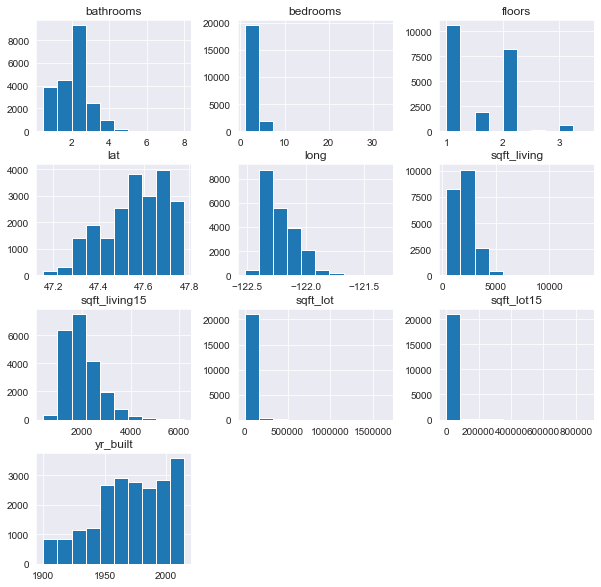

In [68]:
adf3[conts].hist(figsize=(10,10));

In [69]:
adf3.shape

(21420, 36)

In [70]:
# using IQR to remove outliers
# making copy of data frame
ndf = adf3.copy()

In [71]:
ndf.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,grd_A,wntr_spr,spr_summ,summ_fall,fall_wntr,cond_1,cond_2,cond_3,cond_4,cond_5
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0,0,0,0,1,0,0,1,0,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,0,0,0,0,1,0,0,1,0,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0,1,0,0,0,0,0,1,0,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,0,0,0,0,1,0,0,0,0,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0,1,0,0,0,0,0,1,0,0


In [72]:
ndf.shape

(21420, 36)

In [73]:
# List of continuous data that.  Excluding 'lat' and 'long'. 
conts = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
         'yr_built', 'sqft_living15', 'sqft_lot15']
 

In [74]:
# creating a for loop that defines the IQR and Whiskers so we can remove all 
# data outside of the whiskers (outliers)
for cont in conts:
    q1 = ndf[cont].quantile(0.25)
    q3= ndf[cont].quantile(0.75)
    IQR = q3 - q1
    Lower_Whisker = q1 - 1.5*IQR
    Upper_Whisker = q3 + 1.5*IQR
    ndf = ndf[ndf[cont] <= Upper_Whisker]
ndf.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,grd_A,wntr_spr,spr_summ,summ_fall,fall_wntr,cond_1,cond_2,cond_3,cond_4,cond_5
count,1.740900e+04,1.740900e+04,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,...,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000,17409.000000
mean,4.748998e+09,4.806693e+05,3.267563,2.011144,1882.776380,6974.661325,1.478287,0.002068,0.164168,3.415475,...,0.000057,0.193980,0.313573,0.271813,0.220633,0.001034,0.006950,0.649434,0.260670,0.081912
std,2.875410e+09,2.454406e+05,0.814466,0.679562,687.412449,3260.075163,0.546641,0.045428,0.627331,0.653305,...,0.007579,0.395425,0.463959,0.444907,0.414685,0.032139,0.083081,0.477161,0.439013,0.274238
min,2.800031e+06,7.800000e+04,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.310030e+09,3.100000e+05,3.000000,1.500000,1360.000000,4745.000000,1.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.059401e+09,4.260000e+05,3.000000,2.000000,1790.000000,7000.000000,1.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,7.504460e+09,5.890000e+05,4.000000,2.500000,2320.000000,8965.000000,2.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,9.900000e+09,2.750000e+06,5.000000,4.000000,4130.000000,18306.000000,3.500000,1.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


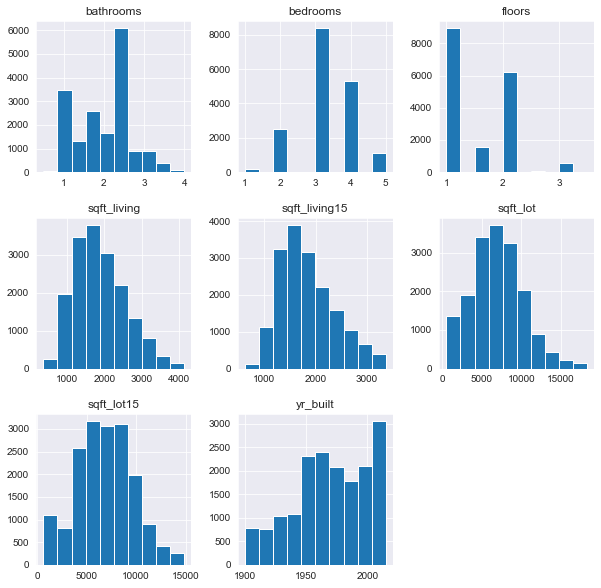

In [75]:
ndf[conts].hist(figsize=(10,10));

In [76]:
ndf.shape

(17409, 36)

Plots are looking much better, but at the cost of data.

In [77]:
target = 'price'

feats = ndf.drop(['price', 'id', 'grd_D', 'wntr_spr', 'condition', 
                  'zipcode', 'quad_1', 'cond_1'], axis=1).columns

preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=ndf).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                    OLS                    Adj. R-squared:           0.687      
Dependent Variable:       price                  AIC:                      461325.9059
Date:                     2020-07-16 19:33       BIC:                      461551.0834
No. Observations:         17409                  Log-Likelihood:           -2.3063e+05
Df Model:                 28                     F-statistic:              1366.      
Df Residuals:             17380                  Prob (F-statistic):       0.00       
R-squared:                0.688                  Scale:                    1.8849e+10 
--------------------------------------------------------------------------------------
                  Coef.        Std.Err.      t     P>|t|      [0.025         0.975]   
--------------------------------------------------------------------------------------
Intercept     -11439676.7448 1505676.5460  -7.5977 0.0000 -14390954.0776 -8488399.4119
bedrooms         -12089.8682    1707.5777  -7.0801 0.0000    -15436.8920    -8742.8444
bathrooms         28972.8039    2665.9515  10.8677 0.0000     23747.2711    34198.3368
sqft_living         131.2740       3.1315  41.9198 0.0000       125.1358      137.4121
sqft_lot             -1.7444       0.6656  -2.6210 0.0088        -3.0490       -0.4398
floors            15389.3769    3021.3196   5.0936 0.0000      9467.2869    21311.4670
waterfront       370712.3712   23886.0424  15.5200 0.0000    323893.3278   417531.4147
view              44944.3042    1837.7226  24.4565 0.0000     41342.1833    48546.4252
basement          -9082.8312    2676.3246  -3.3938 0.0007    -14328.6964    -3836.9660
yr_built          -1593.8460      52.9876 -30.0796 0.0000     -1697.7070    -1489.9851
renovated         10188.4110    2583.1728   3.9441 0.0001      5125.1328    15251.6892
lat              176722.7905   14047.3249  12.5805 0.0000    149188.6221   204256.9590
long             -50620.0211   11163.5621  -4.5344 0.0000    -72501.7245   -28738.3176
sqft_living15        57.8328       3.1357  18.4435 0.0000        51.6865       63.9790
sqft_lot15           -3.3368       0.7732  -4.3156 0.0000        -4.8524       -1.8213
quad_2           -80855.0006    9589.9494  -8.4312 0.0000    -99652.2650   -62057.7362
quad_3          -152877.7021    4452.8817 -34.3323 0.0000   -161605.7978  -144149.6065
quad_4           -46743.2644   13759.6015  -3.3971 0.0007    -73713.4661   -19773.0628
grd_F            -46125.2219   10128.2433  -4.5541 0.0000    -65977.5966   -26272.8472
grd_C             78809.9592    2913.3472  27.0513 0.0000     73099.5060    84520.4124
grd_B            325057.7878    7376.8383  44.0646 0.0000    310598.4434   339517.1322
grd_A           1453240.0860  137474.5325  10.5710 0.0000   1183776.1878  1722703.9843
spr_summ          -3363.0420    3012.2528  -1.1165 0.2642     -9267.3601     2541.2761
summ_fall        -20901.5291    3102.6432  -6.7367 0.0000    -26983.0216   -14820.0366
fall_wntr        -21887.6018    3243.0181  -6.7491 0.0000    -28244.2431   -15530.9605
cond_2            78537.2022   34755.3190   2.2597 0.0239     10413.2845   146661.1199
cond_3           103714.9519   32569.0413   3.1845 0.0015     39876.3582   167553.5457
cond_4           137429.1732   32579.4816   4.2183 0.0000     73570.1154   201288.2310
cond_5           162497.4051   32722.2441   4.9660 0.0000     98358.5185   226636.2917
--------------------------------------------------------------------------------------
Omnibus:                    7227.325            Durbin-Watson:               1.983    
Prob(Omnibus):              0.000               Jarque-Bera (JB):            74841.259
Skew:                       1.710               Prob(JB):                    0.000    
Kurtosis:                   12.564              Condition No.:  

R2 has dropped, but skew and kurtosis have decreased substantially. Standard errors have decreased, as well. Checking for correlation. 

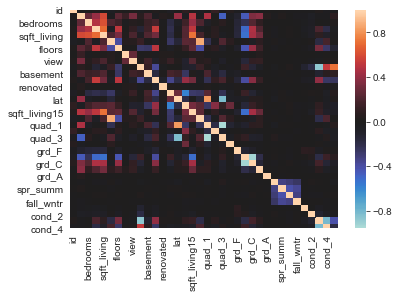

In [78]:
sns.heatmap(ndf.corr(), center=0)

In [79]:
# creating a date frame that only contains the pairs of values with highest 
# correlation

# converts all elements to absolute values, stacks into multi-index, resets 
# the index to set the multi-index to seperate columns, and finally sorts them
corr_pairs = ndf.corr().abs().stack().reset_index().sort_values(0, 
                                                                ascending=False)
# zipping the variable name columns
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

#set index to the pairs
pairs_index = corr_pairs.set_index(['pairs'])

#dropping level columns
pairs = pairs_index.drop(columns=['level_0', 'level_1'])

#renaming column for comprehension
pairs.columns = ['correlation']
#Since our heatmap shows that our variables only show perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

In [80]:
unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(quad_3, quad_1)",0.948916
"(grd_D, grd_C)",0.919722
"(sqft_lot15, sqft_lot)",0.870651
"(condition, cond_3)",0.865613
"(lat, quad_3)",0.827097
"(lat, quad_1)",0.825845
"(cond_4, cond_3)",0.808182


In [81]:
# Drop grd_D, cond_3, quad_3, sqft_lot15 (statistically insignificant)
target = 'price'

feats = ndf.drop(['price', 'id', 'grd_D', 'wntr_spr', 'condition', 
                  'zipcode', 'quad_3', 'cond_3', 'sqft_lot15'], 
                 axis=1).columns

preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=ndf).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                    OLS                    Adj. R-squared:           0.687      
Dependent Variable:       price                  AIC:                      461340.6830
Date:                     2020-07-16 19:33       BIC:                      461558.0958
No. Observations:         17409                  Log-Likelihood:           -2.3064e+05
Df Model:                 27                     F-statistic:              1415.      
Df Residuals:             17381                  Prob (F-statistic):       0.00       
R-squared:                0.687                  Scale:                    1.8866e+10 
--------------------------------------------------------------------------------------
                  Coef.        Std.Err.      t     P>|t|      [0.025         0.975]   
--------------------------------------------------------------------------------------
Intercept     -11514102.1387 1504391.9351  -7.6537 0.0000 -14462861.4932 -8565342.7841
bedrooms         -12470.3111    1706.0594  -7.3094 0.0000    -15814.3590    -9126.2632
bathrooms         29381.9381    2665.6373  11.0225 0.0000     24157.0211    34606.8550
sqft_living         131.5593       3.1322  42.0017 0.0000       125.4198      137.6988
sqft_lot             -3.9884       0.4136  -9.6442 0.0000        -4.7990       -3.1778
floors            17586.0891    2977.6962   5.9059 0.0000     11749.5055    23422.6728
waterfront       367387.3270   23884.8237  15.3816 0.0000    320570.6725   414203.9815
view              44936.9015    1838.5557  24.4414 0.0000     41333.1476    48540.6553
basement          -8596.7080    2674.7255  -3.2141 0.0013    -13839.4388    -3353.9773
yr_built          -1607.5354      52.9091 -30.3830 0.0000     -1711.2425    -1503.8282
renovated         10135.3082    2584.2044   3.9220 0.0001      5070.0079    15200.6084
lat              172533.7188   14028.6451  12.2987 0.0000    145036.1649   200031.2727
long             -52608.7112   11160.9231  -4.7137 0.0000    -74485.2420   -30732.1804
sqft_living15        56.1081       3.1126  18.0261 0.0000        50.0071       62.2091
quad_1           154643.4424    4439.8043  34.8311 0.0000    145940.9799   163345.9050
quad_2            74899.5387    9898.2344   7.5670 0.0000     55498.0047    94301.0728
quad_4           104883.9431   13662.5399   7.6768 0.0000     78103.9921   131663.8940
grd_F            -46439.4849   10130.6095  -4.5841 0.0000    -66296.4974   -26582.4723
grd_C             78638.1590    2914.4936  26.9818 0.0000     72925.4587    84350.8593
grd_B            323558.4883    7372.2769  43.8885 0.0000    309108.0848   338008.8917
grd_A           1459574.9893  137528.9673  10.6129 0.0000   1190004.3944  1729145.5842
spr_summ          -3442.2251    3013.5015  -1.1423 0.2534     -9348.9909     2464.5407
summ_fall        -20869.2965    3104.0041  -6.7233 0.0000    -26953.4565   -14785.1366
fall_wntr        -21801.2773    3244.4294  -6.7196 0.0000    -28160.6849   -15441.8696
cond_1          -101824.0258   32580.0308  -3.1254 0.0018   -165684.1599   -37963.8917
cond_2           -25360.6117   12680.1287  -2.0000 0.0455    -50214.9379     -506.2854
cond_4            32873.2991    2632.6421  12.4868 0.0000     27713.0561    38033.5420
cond_5            58229.2213    4136.0331  14.0785 0.0000     50122.1809    66336.2617
--------------------------------------------------------------------------------------
Omnibus:                    7196.536            Durbin-Watson:               1.984    
Prob(Omnibus):              0.000               Jarque-Bera (JB):            74315.964
Skew:                       1.702               Prob(JB):                    0.000    
Kurtosis:                   12.532              Condition No.:               11987577 
================================================================